<a href="https://colab.research.google.com/github/mohan-mj/Tagging-Stack-Overflow-posts-NLP-Case_Study/blob/master/Tagging_Stack_Overflow_posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils  

Using TensorFlow backend.


## Getting the comment data

Data is at the core of any machine learning problem. To build our text classification model, we’ll need to train it on a large dataset of Stack Overflow questions. After training our model, we’ll also need a test dataset to check its accuracy with data it has never seen before. Our first step is getting the Stack Overflow questions and tags. This data is available as a public dataset.

In [0]:
!wget -q https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

In [5]:
data = pd.read_csv("stack-overflow-data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
post    40000 non-null object
tags    40000 non-null object
dtypes: object(2)
memory usage: 625.1+ KB


,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


In [6]:
# Confirm that we have a balanced dataset

data['tags'].value_counts()

ruby-on-rails    2000
python           2000
asp.net          2000
c#               2000
css              2000
iphone           2000
android          2000
sql              2000
php              2000
ios              2000
c++              2000
.net             2000
javascript       2000
angularjs        2000
html             2000
objective-c      2000
java             2000
c                2000
mysql            2000
jquery           2000
Name: tags, dtype: int64

In [7]:
# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 32000
Test size: 8000


In [0]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

# Bag of words model

## Preprocessing data

We’ll use a simple Bag of Words model to classify questions. This type of model takes the collection of words in each post as input. It will be able to determine whether each word appears in a post, but it won’t understand grammar or sequence  (think of the inputs as a bag of Scrabble tiles, where each tile represents a word). For example, our model will be able to understand that the words “screen” and “listview” are frequently tagged as Android, but it won’t know anything about the order in which they frequently appear.

 ## Processing input features

Our input data is the post title and body, but we can’t feed text directly into our model. Instead, we need to put it into numeric representation, which is a format the model can understand. To do this, we’ll create an array of the top words in our vocabulary. A comment will be represented by a dense vector of our vocabulary size, with a 0 or 1 indicating the absence or presence of a given word from the vocabulary in a comment.

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

## Processing output labels
The tag for each question is a string (i.e. “javascript” or “php”). First, we’ll need to encode each tag as an integer. But instead of using a single int as the label for each input, we’ll turn it into a one-hot vector.

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [13]:

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

## Building the model
To define the layers of our model we’ll use the Keras Sequential model API. This lets us easily define the shape of our input data and the type of layers that make up our model.

In [16]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               512512    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                10260     
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
Total params: 522,772
Trainable params: 522,772
Non-trainable params: 0
_________________________________________________________________


## Training and evaluating the model
To prepare our model for training, we need to call the compile method with the loss function we want to use, the type of optimizer, and the metrics our model should evaluate during training and testing. We’ll use the cross entropy loss function, since each of our comments can only belong to one post. The optimizer is the function our model uses to minimize loss. In this example we’ll use the Adam optimizer. There are many optimizers available, all of which are different implementations of gradient descent 

In [17]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

W0818 16:50:30.811574 140493568624512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28800 samples, validate on 3200 samples
Epoch 1/2
28800/28800 [==============================] - 12s 432us/step - loss: 0.9758 - acc: 0.7161 - val_loss: 0.6035 - val_acc: 0.8125
Epoch 2/2
28800/28800 [==============================] - 12s 409us/step - loss: 0.5507 - acc: 0.8234 - val_loss: 0.5937 - val_acc: 0.8081


In [18]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8000/8000 [==============================] - 1s 71us/step
Test score: 0.6023550906777382
Test accuracy: 0.80725


## Generating predictions

In [19]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

jquery( tr_selector ) is removing the style values ...
Actual label:jquery
Predicted label: jquery

web reference in wcf  in wcf if we use webreferenc ...
Actual label:.net
Predicted label: .net

fragment transaction custom animation - android  i ...
Actual label:android
Predicted label: android

why can i not use the namespace directive in c++ s ...
Actual label:c++
Predicted label: c++

generating password reset link in c# .net  i must  ...
Actual label:.net
Predicted label: c#

php 5.3 $this versus php 5.4  i am calling a membe ...
Actual label:php
Predicted label: php

undefined method `request_uri  actiondispatch  i w ...
Actual label:ruby-on-rails
Predicted label: ruby-on-rails

my table view is not showing data  i am using a ta ...
Actual label:iphone
Predicted label: iphone

update panel not working correctly   i have added  ...
Actual label:asp.net
Predicted label: asp.net

floating objects in html  is it possible to make a ...
Actual label:html
Predicted label: html



In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:

import itertools
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

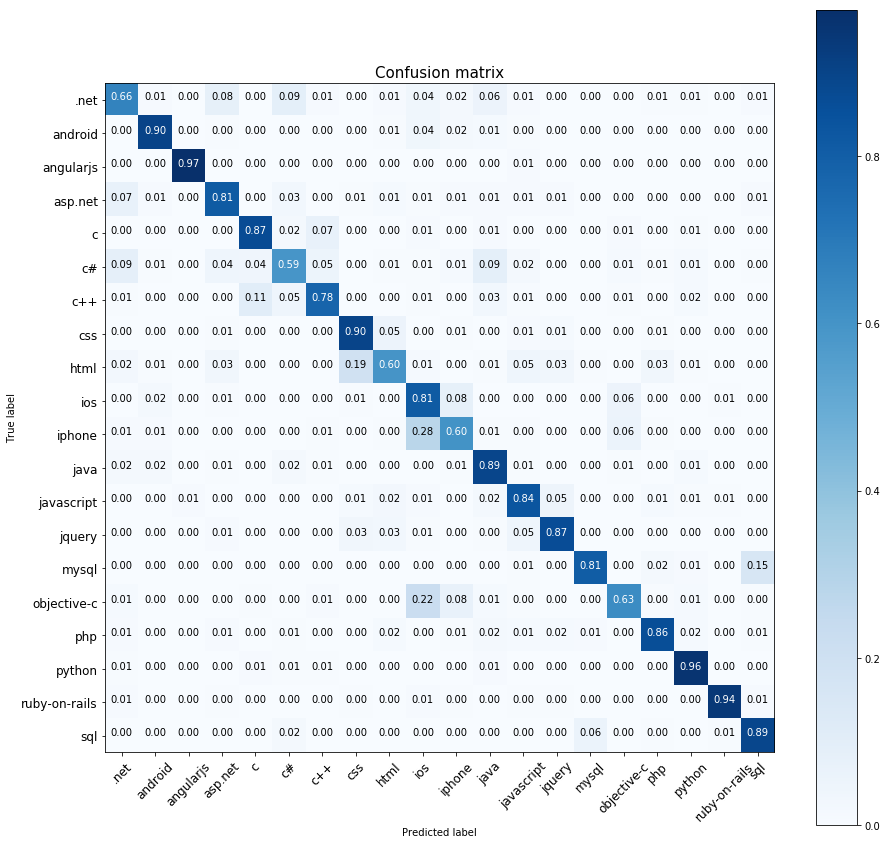

In [34]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()